<a href="https://colab.research.google.com/github/AnushaBethini/KDD_project_group7/blob/main/final_deliverable2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

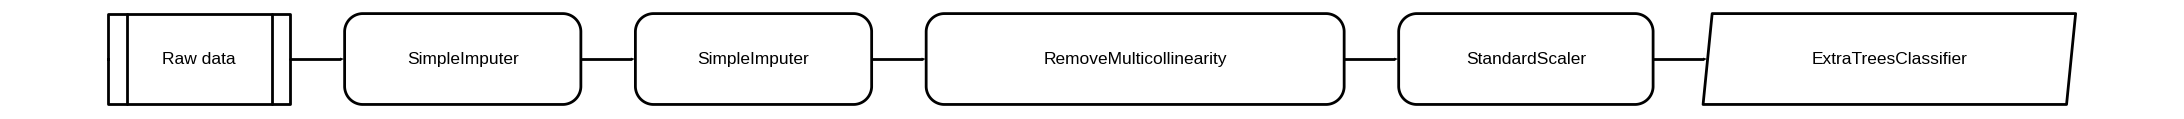

Transformation Pipeline and Model Successfully Saved


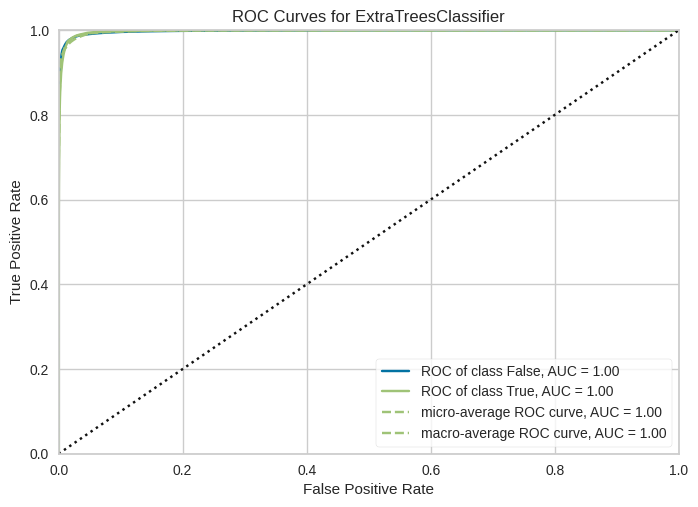

Best Scikit-learn Model: Random Forest
ROC-AUC Score: 0.95

Model: Logistic Regression
ROC-AUC Score: 0.84
Classification Report:
              precision    recall  f1-score       support
False          0.880630  0.988339  0.931381  59088.000000
True           0.478030  0.073827  0.127901   8547.000000
accuracy       0.872773  0.872773  0.872773      0.872773
macro avg      0.679330  0.531083  0.529641  67635.000000
weighted avg   0.829754  0.872773  0.829846  67635.000000
Confusion Matrix:
[[58399   689]
 [ 7916   631]]

Model: Decision Tree
ROC-AUC Score: 0.75
Classification Report:
              precision    recall  f1-score      support
False          0.938216  0.935977  0.937095  59088.00000
True           0.564572  0.573886  0.569191   8547.00000
accuracy       0.890220  0.890220  0.890220      0.89022
macro avg      0.751394  0.754931  0.753143  67635.00000
weighted avg   0.890999  0.890220  0.890603  67635.00000
Confusion Matrix:
[[55305  3783]
 [ 3642  4905]]

Model: Random Fo

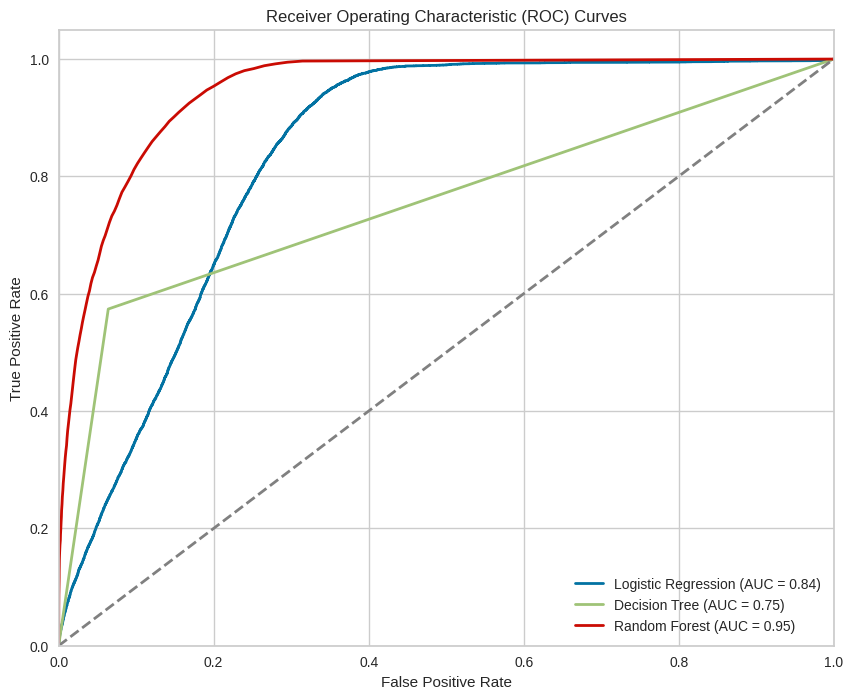


Best PyCaret Model: ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from pycaret.classification import *

# Load the dataset
df = pd.read_csv('/content/nearest-earth-objects(1910-2024).csv')

# Handle missing values
df = df.dropna()

# Feature Engineering: Calculate average diameter
df['estimated_diameter_avg'] = (df['estimated_diameter_min'] + df['estimated_diameter_max']) / 2

# Select features and target variable
features = ['absolute_magnitude', 'estimated_diameter_avg', 'relative_velocity', 'miss_distance']
X = df[features]
y = df['is_hazardous']

# Combine features and target into a single DataFrame
data = X.copy()
data['is_hazardous'] = y

# Initialize the PyCaret environment
clf = setup(data, target='is_hazardous', session_id=42,
            normalize=True,  # Normalize features
            remove_multicollinearity=True,  # Remove multicollinearity
            ignore_features=None)  # Do not ignore any features

# Compare models using PyCaret
best_model_pycaret = compare_models()

# Evaluate the best PyCaret model
evaluate_model(best_model_pycaret)

# Finalize and save the PyCaret model
final_model_pycaret = finalize_model(best_model_pycaret)
save_model(final_model_pycaret, 'best_neo_model_pycaret')

# Plot ROC curve for the best PyCaret model
plot_model(final_model_pycaret, plot='auc')

# --- Traditional scikit-learn Models ---
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Function to evaluate models
def evaluate_model_sklearn(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    confusion = confusion_matrix(y_test, y_pred)
    return report, roc_auc, confusion

# Evaluate all scikit-learn models
results = {}
for model_name, model in models.items():
    report, roc_auc, confusion = evaluate_model_sklearn(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results[model_name] = {'report': report, 'roc_auc': roc_auc, 'confusion': confusion}

# Print the results for scikit-learn models
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
print(f"Best Scikit-learn Model: {best_model_name}")
print(f"ROC-AUC Score: {results[best_model_name]['roc_auc']:.2f}")

# Display all model results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"ROC-AUC Score: {metrics['roc_auc']:.2f}")
    print("Classification Report:")
    print(pd.DataFrame(metrics['report']).transpose())
    print("Confusion Matrix:")
    print(metrics['confusion'])

# Plot ROC curves for all scikit-learn models
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

print(f"\nBest PyCaret Model: {best_model_pycaret}")

